# ChromVAR

Run ChromVAR manually.

In [ ]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(BiocParallel)
set.seed(2017)

In [2]:
register(MulticoreParam(20, progressbar = TRUE))

In [4]:
PFM_DIR = './data/neurallike_modisco/'
PFM_FILES = list.files(PFM_DIR)
PFM_NAMES = lapply(strsplit(PFM_FILES, "\\."), "[[", 1)
PFM_FILES = paste(PFM_DIR, PFM_FILES, sep='')
PFM_NAMES
PFM_FILES

[[1]]
[1] "pattern_0"

[[2]]
[1] "pattern_1"

[[3]]
[1] "pattern_2"

[[4]]
[1] "pattern_3"

[[5]]
[1] "pattern_4"

[[6]]
[1] "pattern_5"

[[7]]
[1] "pattern_6"

[[8]]
[1] "pattern_7"

[[9]]
[1] "pattern_8"

[1] "./data/neurallike_modisco/pattern_0.pfm"
[2] "./data/neurallike_modisco/pattern_1.pfm"
[3] "./data/neurallike_modisco/pattern_2.pfm"
[4] "./data/neurallike_modisco/pattern_3.pfm"
[5] "./data/neurallike_modisco/pattern_4.pfm"
[6] "./data/neurallike_modisco/pattern_5.pfm"
[7] "./data/neurallike_modisco/pattern_6.pfm"
[8] "./data/neurallike_modisco/pattern_7.pfm"
[9] "./data/neurallike_modisco/pattern_8.pfm"

In [5]:
MAX_MOTIF_LEN = 30
pfms = list()
j = 1 
for (i in seq(length(PFM_FILES))) {
    raw_pfms = t(as.matrix(read.table(PFM_FILES[i])))
    rownames(raw_pfms) = c("A", "C", "G", "T")
    if (ncol(raw_pfms) < MAX_MOTIF_LEN) {
        pfms[[j]] = PFMatrix(ID=unlist(PFM_NAMES[i]),
                            name=unlist(PFM_NAMES[i]),
                            bg=c(A=0.25, C=0.25, G=0.25, T=0.25),
                            profileMatrix=raw_pfms)
        j = j+1
    }
}

In [6]:
motifs = do.call(PFMatrixList, c(pfms, use.names=T))
motifs

PFMatrixList of length 4

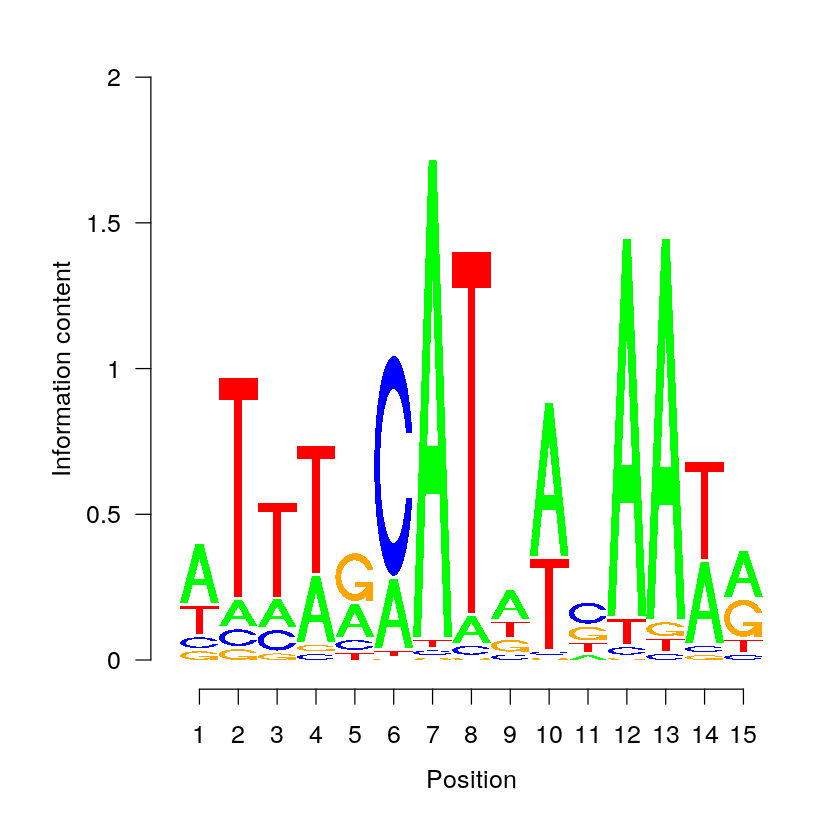

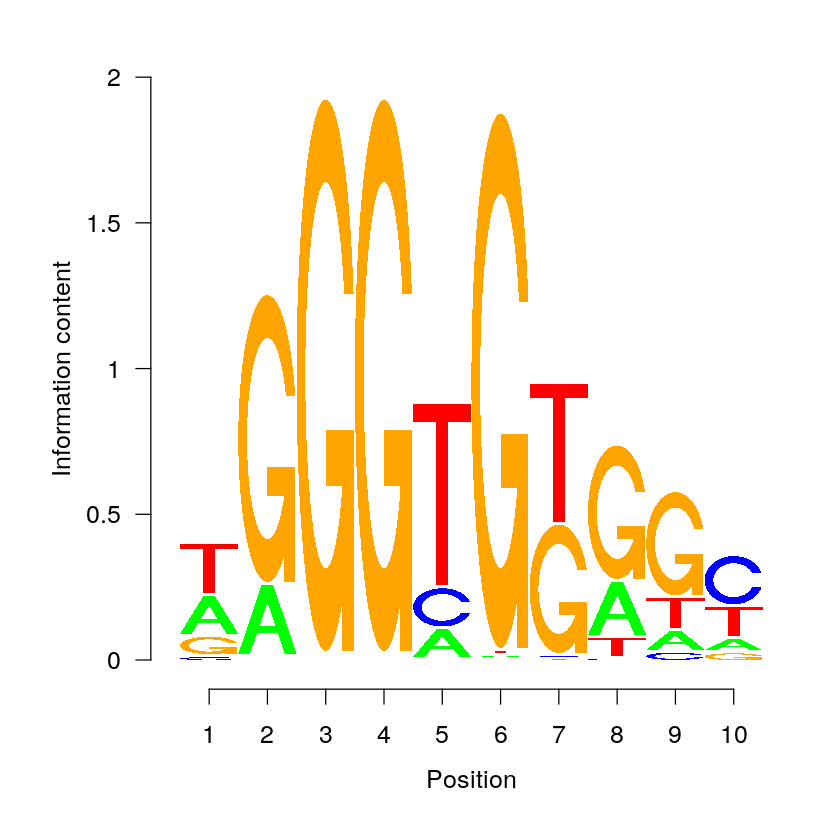

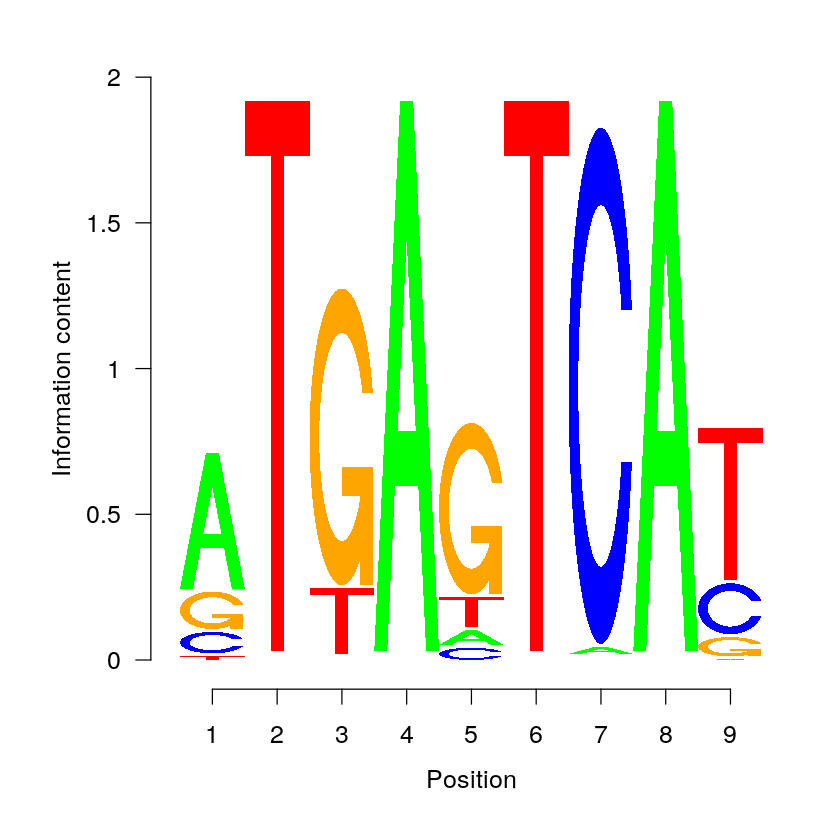

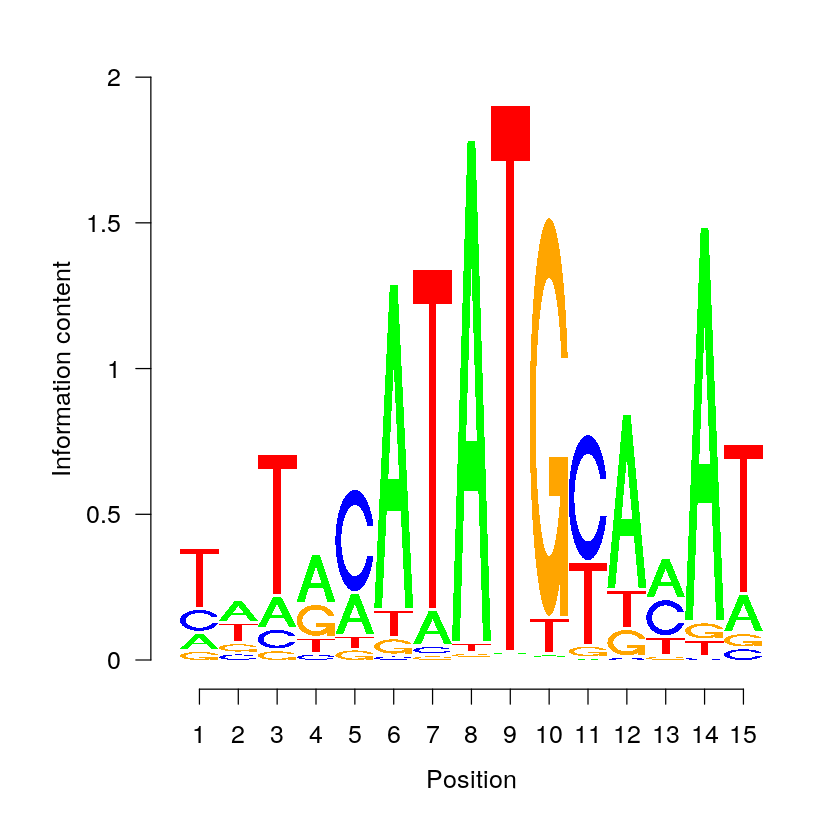

In [7]:
for (i in seq(length(motifs))) {
    icm <- toICM(pfms[[i]], pseudocounts=0.8, schneider=TRUE)
    seqLogo(icm)
}

In [8]:
motif_names = c()
for (i in seq(length(motifs))) {
    motif_names = c(motif_names, name(motifs[[i]]))
}
motif_names

[1] "pattern_0" "pattern_1" "pattern_2" "pattern_3"

## Load Data

In [9]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [10]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [11]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [12]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145604-97145864      *
       [2]     chr1     7538148-7538363      *
       [3]     chr1   93196678-93196894      *
       [4]     chr1 187577713-187577913      *
       [5]     chr1   53278065-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500307-7500509      *
  [803955]     chrY     7447984-7448191      *
  [803956]     chrY   14733640-14733856      *
  [803957]     chrY   12662452-12662752      *
  [803958]     chrY   12681580-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [13]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [14]:
pmatRowSums = Matrix::rowSums(pmat)

In [15]:
pmatColSums = Matrix::colSums(pmat)

In [16]:
min(pmatRowSums)

[1] 316

In [17]:
min(pmatColSums)

[1] 21

## ChromVAR

In [18]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [19]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [20]:
rse <- addGCBias(rse, genome = GENOME);

In [21]:
motif_mm <- matchMotifs(motifs, rse, genome = GENOME);

In [22]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_names

In [23]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

  |======================================================================| 100%



In [24]:
dev_mat = t(assay(dev))

In [25]:
colnames(dev_mat) = motif_names
head(dev_mat)

pattern_0,pattern_1,pattern_2,pattern_3
-0.4237171,-0.2122412,0.06820018,-0.2747425
-0.4166728,-0.2240881,0.11762159,-0.3746625
-0.4197173,-0.2143905,0.12068768,-0.2860685
-0.4184432,-0.2110715,0.15578101,-0.3695057
-0.2493135,-0.2602220,0.05149586,-0.2363459
-0.4084993,-0.1902993,0.26871587,-0.3454023


In [26]:
variability <- computeVariability(dev)

  |======================================================================| 100%



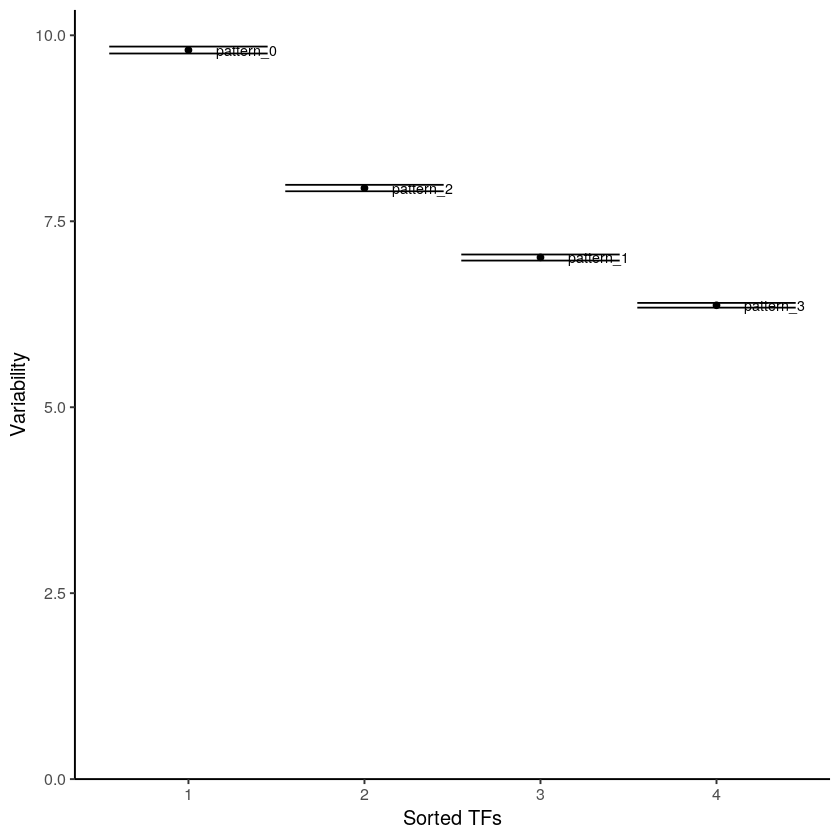

In [27]:
plotVariability(variability, use_plotly = FALSE, n = 10) 

In [63]:
cur_pattern = "pattern_1"

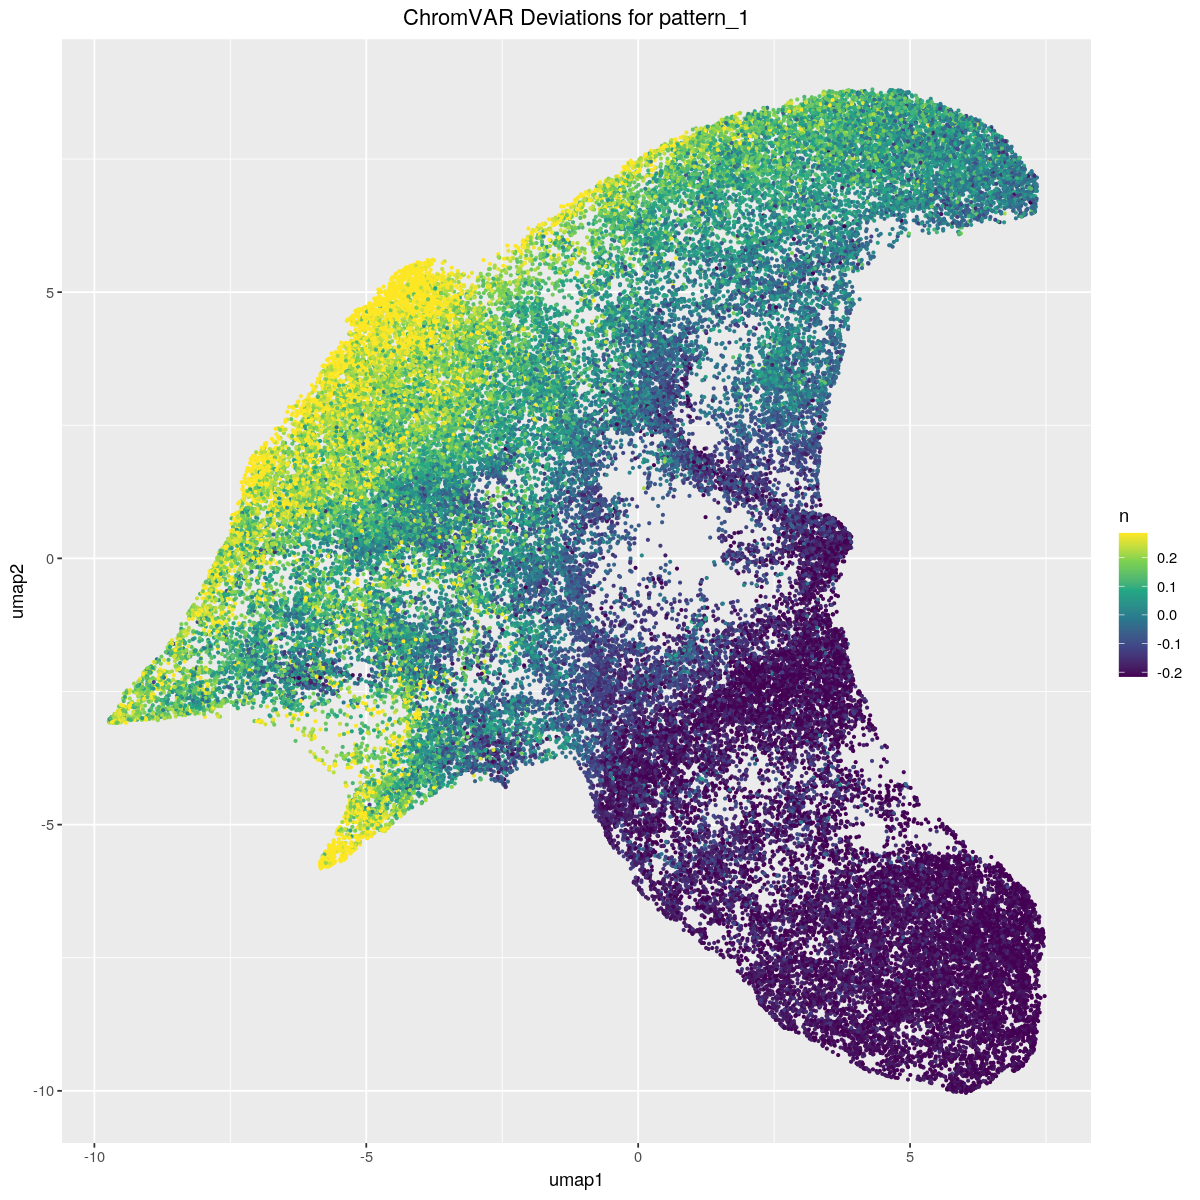

In [64]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.1),
                              quantile(cur_dev, 0.95)), 
                      oob = squish) +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) 

In [65]:
sum(motif_mm_mat[, cur_pattern])

[1] 91694

In [66]:
frip = 100*Matrix::rowSums(pmat[, motif_mm_mat[, cur_pattern]])/pmatRowSums

In [67]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.9428294

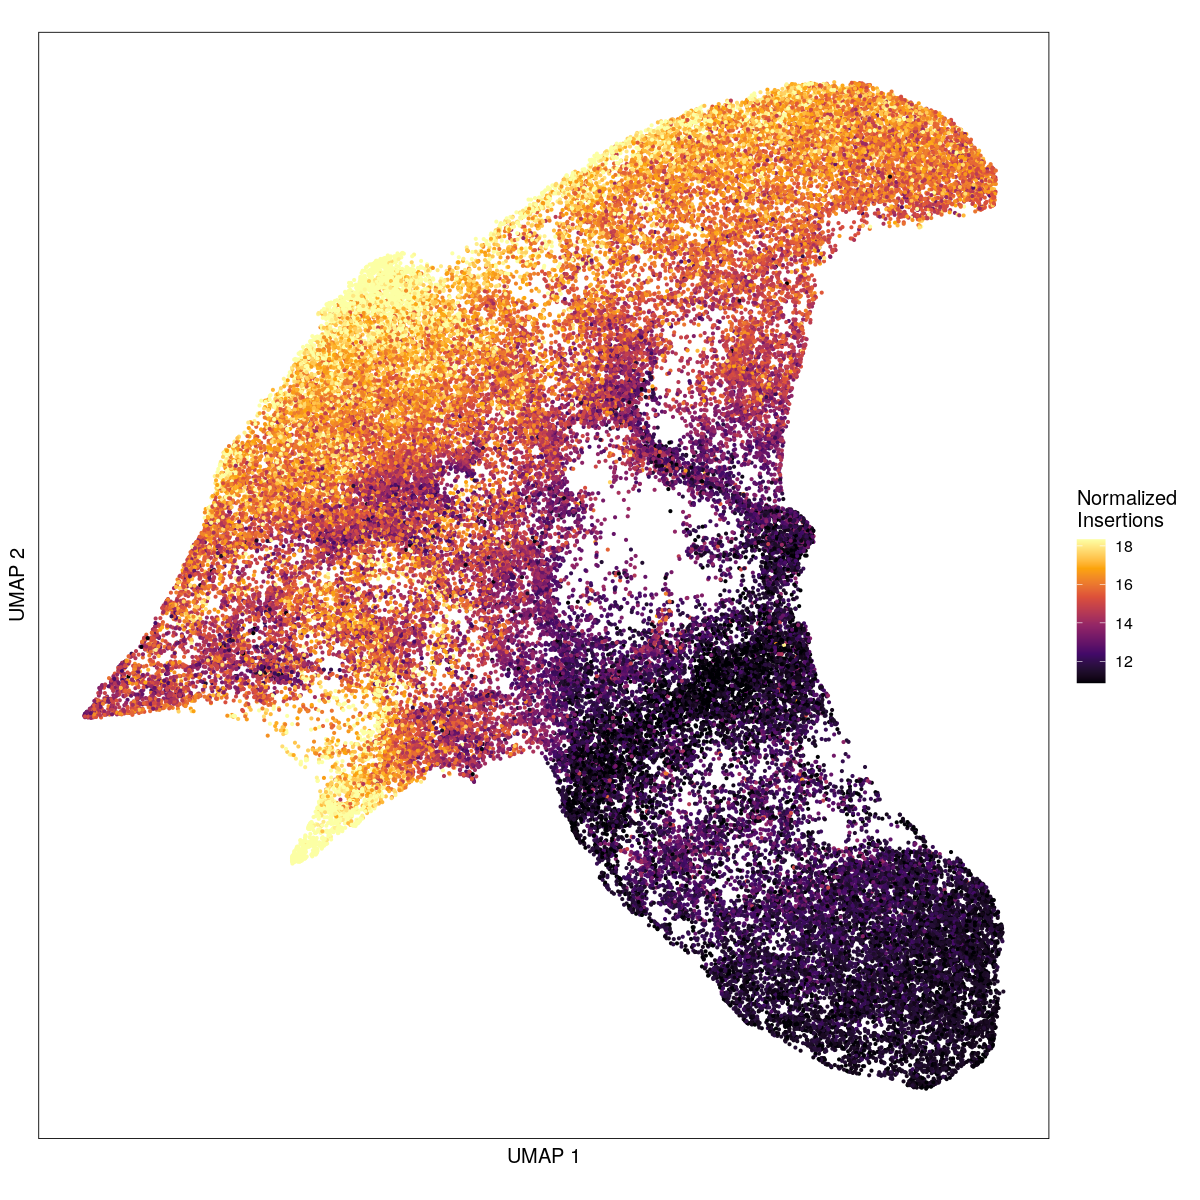

In [68]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.05),
                              quantile(frip, 0.95)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

### SessionInfo

In [236]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.0                      ggplot2_3.3.0                    
 [3] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [5] DelayedArray_0.12.3               BiocParallel_1.20.1              
 [7] matrixStats_0.56.0                Biobase_2.46.0   